In [2]:
# export
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
sys.path.insert(0,"/content/drive/My Drive/Colab Notebooks/exp")
from nb_05b import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## ConvNet

In [0]:
x_train, y_train, x_valid, y_valid = get_data()

Helper function to quickly normalize with the mean and standard deviation from our training set:

In [0]:
# export

def normalize(x,m,s):
  return (x-m)/s
  
def normalize_to(train, valid):
  m,s = train.mean(), train.std()
  return normalize(train, m, s), normalize(valid, m, s)

In [0]:
x_train, x_valid = normalize_to(x_train, x_valid)
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)


Let's check it behaved properly.

In [7]:
x_train.mean(), x_train.std()

(tensor(0.0001), tensor(1.))

In [0]:
nh, bs = 50, 512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = Databunch(*get_dls(train_ds, valid_ds, bs), c)

To refactor layers, it's useful to have a Lambda layer that can take a basic function and convert it to a layer you can put in `nn.Sequential`.

NB: if you use a Lambda layer with a lambda function, your model won't pickle so you won't be able to save it with PyTorch. So it's best to give a name to the function you're using inside your Lambda (like flatten below).

In [0]:
# export
class Lambda(nn.Module):
  def __init__(self, func):
    super().__init__()
    self.func = func

  def forward(self, x): return self.func(x)

def flatten(x):
  return x.view(x.shape[0],-1)


This one takes the flat vector of size bs x 784 and puts it back as a batch of images of 28 by 28 pixels:

In [0]:
def mnist_resize(x):
  return x.view(-1,1,28,28)

We can now define a simple CNN

In [0]:
def get_cnn_model(data):
  return nn.Sequential(
      Lambda(mnist_resize),
      nn.Conv2d(1,8,5,padding=2,stride=2), nn.ReLU(), #14
      nn.Conv2d(8, 16, 3, padding=1, stride=2), nn.ReLU(), #7
      nn.Conv2d(16, 32, 3, padding=1, stride=2), nn.ReLU(), #2
      nn.AdaptiveAvgPool2d(1),
      Lambda(flatten),
      nn.Linear(32,data.c) 
  )

In [0]:
model = get_cnn_model(data)

Basic callbacks from the previous notebook:

In [0]:
cbfs = [Recorder, partial(AvgStatsCallback, accuracy)]

In [0]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [15]:
%time run.fit(1, learn)

CPU times: user 4.04 s, sys: 138 ms, total: 4.18 s
Wall time: 4.34 s


## CUDA


This took a long time to run, so it's time to use a GPU. A simple Callback can make sure the model, inputs and targets are all on the same device.

In [0]:
# Somewhat more flexible way
device = torch.device('cuda', 0)

In [0]:
class CudaCallback(Callback):
  def __init__(self, device): self.device = device
  def begin_fit(self): self.model.to(self.device)
  def begin_batch(self): 
    self.run.xb, self.run.yb = self.xb.to(self.device), self.yb.to(self.device)

In [18]:
# Somewhat less flexible, but quite convenient
print(f'is CUDA available: {torch.cuda.is_available()}')
torch.cuda.set_device(device)

is CUDA available: True


In [19]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [0]:
# export
class CudaCallback(Callback):
  def begin_fit(self): self.model.cuda()
  def begin_batch(self): self.run.xb, self.run.yb = self.xb.cuda(), self.yb.cuda()

In [0]:
cbfs.append(CudaCallback)

In [0]:
model = get_cnn_model(data)

In [0]:
opt = optim.SGD(model.parameters(), lr = 0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [24]:
%time run.fit(3, learn)

CPU times: user 4.71 s, sys: 1.18 s, total: 5.89 s
Wall time: 8.7 s


Now, that's definitely faster!

## Refactor model

First we can regroup all the conv/relu in a single function

In [0]:
def conv2d(ni, nf, ks=3,stride=2):
  return nn.Sequential(
      nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU()
  )

Another thing is that  we can do the mnist resize in a batch transform, that we can do with a Callback

In [0]:
# export
class BatchTransformXCallback(Callback):
  _order = 2
  def __init__(self, tfms): self.tfms = tfms
  def begin_batch(self):
    self.run.xb = self.tfms(self.xb)

def view_tfm(*size):
  def _inner(x):
    return x.view(*((-1,)+size))
  return _inner

In [0]:
mnist_view = view_tfm(1,28,28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

With the `AdaptiveAvgPool`, this model can now work on any size input:

In [0]:
nfs = [8, 16, 32, 32]

In [0]:
def get_cnn_layers(data, nfs):
  nfs = [1] + nfs
  return [
          conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
          for i in range(len(nfs) - 1)
  ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs):
  return nn.Sequential(*get_cnn_layers(data, nfs))

And this helper function will quickly give us everything needed to run the training.

In [0]:
# export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func=F.cross_entropy):
  if opt_func is None: opt_func = optim.SGD
  opt = opt_func(model.parameters(), lr = lr)
  learn = Learner(model, opt, loss_func, data)
  return learn, Runner(cb_funcs=listify(cbs))

In [0]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [32]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [0]:
run.fit(3, learn)

## Hooks

### Manual insertion


Let's say we want to do some telemetry, and want the mean and standard deviation of each activations in the model. First we can do it manually like this:

In [0]:
class SequentialModel(nn.Module):
  def __init__(self, *layers):
    super().__init__()
    self.layers = nn.ModuleList(layers)
    self.act_means = [[] for _ in layers]
    self.act_stds = [[] for _ in layers]

  def __call__(self, x):
    for i, l in enumerate(self.layers):
      x = l(x)
      self.act_means[i].append(x.data.mean())
      self.act_stds[i].append(x.data.std())
    return x

  def __iter__(self):
    return iter(self.layers)

    

In [0]:
model = SequentialModel(*get_cnn_layers(data, nfs))
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [0]:
run.fit(2, learn)

Now we can have a look at the means and stds of the activations at the beginning of training.



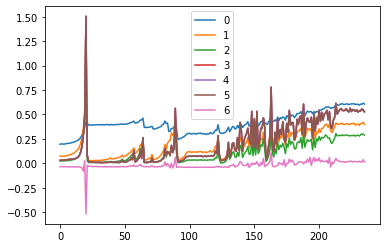

In [37]:
for l in model.act_means:
  plt.plot(l)

plt.legend(range(10))

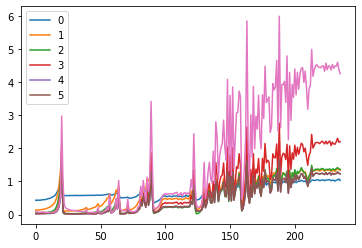

In [38]:
for l in model.act_stds:
  plt.plot(l)

plt.legend(range(6))

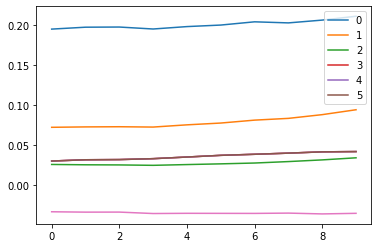

In [39]:
for l in model.act_means:
  plt.plot(l[:10])

plt.legend(range(6))

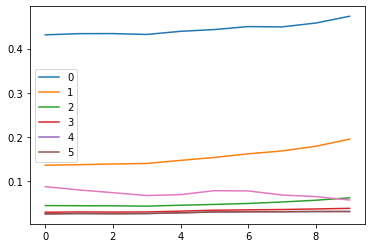

In [40]:
for l in model.act_stds:
  plt.plot(l[:10])
plt.legend(range(6))

### Pytorch hooks

Hooks are PyTorch object you can add to any nn.Module. A hook will be called when a layer, it is registered to, is executed during the forward pass (forward hook) or the backward pass (backward hook).

Hooks don't require us to rewrite the model.

In [0]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr = 0.5, cbs= cbfs)

In [0]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

In [0]:
def append_stats(i, md, inp, outp):
  act_means[i].append(outp.data.mean())
  act_stds[i].append(outp.data.std())

In [0]:
# Using register_forward_hook the following method will be called during forward 
# pass of tht model
for i, m in enumerate(model):
  m.register_forward_hook(partial(append_stats, i))

In [0]:
run.fit(1, learn)

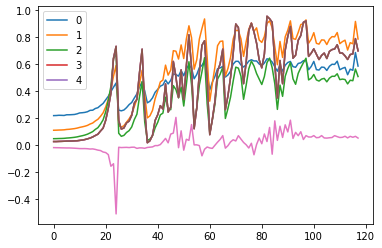

In [46]:
for o in act_means:
  plt.plot(o)

plt.legend(range(5))

### Hook class


We can refactor this in a Hook class. It's very important to remove the hooks when they are deleted, otherwise there will be references kept and the memory won't be properly released when your model is deleted.



In [0]:
# export
def children(m):
  return list(m.children())

class Hook():
  def __init__(self, m, f):
    self.hook = m.register_forward_hook(partial(f, self))

  def remove(self):
    self.hook.remove()

  def __del__(self):
    self.remove

def append_stats(hook, mod, inp, outp):
  if not hasattr(hook, 'stats'): hook.stats = ([],[])
  means, stds = hook.stats
  means.append(outp.data.mean())
  stds.append(outp.data.std())


NB: In fastai we use a bool param to choose whether to make it a forward or backward hook. In the above version we're only supporting forward hooks.

In [0]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [0]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [0]:
run.fit(1, learn)

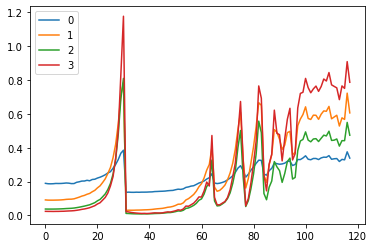

In [51]:
for h in hooks:
  plt.plot(h.stats[0])
  h.remove()

plt.legend(range(6))

### A Hooks class

Let's design our own class that can contain a list of objects. It will behave a bit like a numpy array in the sense that we can index into it via:

*    a single index
*    a slice (like 1:5)
*    a list of indices
*    a mask of indices (`[True,False,False,True,...]`)

The `__iter__` method is there to be able to do things like for x in ....

In [0]:
# export
class ListContainer():
  def __init__(self, items):
    self.items = listify(items)

  def  __getitem__(self, idx):
    if isinstance(idx, (int, slice)):
      return self.items[idx]

    if isinstance(idx[0], bool):
      assert len(idx) == len(self) #bool mask
      return [o for m, o in zip(idx, self.items) if m]

    return [self.items[i] for i in idx]

  def __len__(self): return len(self.items)
  def __iter__(self): return iter(self.items)
  def __setitem__(self, i, o): self.items[i] = o
  def __delitem__(self, i): del(self.items[i])
  def __repr__(self):
    res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
    if len(self)>10: res = res[:-1]+'...]'
    return res
 

In [53]:
ListContainer(range(20))

ListContainer (20 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [54]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [0]:
t = ListContainer(range(10))

In [56]:
t[[1,2]], t[[False]*8 + [True, True]]

([1, 2], [8, 9])

We can use it to write a Hooks class that contains several hooks. We will also use it in the next notebook as a container for our objects in the data block API.

In [0]:
# export
from torch.nn import init

class Hooks(ListContainer):
  def __init__(self, ms, f):
    super().__init__([Hook(m, f) for m in ms])
  
  def __enter__(self, *args): return self
  def __exit__(self, *args): self.remove()
  def __del__(self): self.remove()
    
  def __delitem__(self, i):
    self[i].remove()
    super().__delitem__(i)
    
  def remove(self):
    for h in self: h.remove()

In [0]:
model = get_cnn_model(data, nfs).cuda()
learn, run = get_runner(model, data, lr=0.9, cbs= cbfs)

In [59]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7f5f72b17d30>, <__main__.Hook object at 0x7f5f72b17c88>, <__main__.Hook object at 0x7f5f72b170b8>, <__main__.Hook object at 0x7f5f72b17ac8>, <__main__.Hook object at 0x7f5f72d39358>, <__main__.Hook object at 0x7f5f72d39fd0>, <__main__.Hook object at 0x7f5f733128d0>]

In [0]:
hooks.remove()

In [0]:
x, y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [62]:
x.mean(), x.std()

(tensor(-0.0065, device='cuda:0'), tensor(0.9928, device='cuda:0'))

In [63]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.2663, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.3456, device='cuda:0', grad_fn=<StdBackward0>))

Having given an `__enter__` and `__exit__` method to our Hooks class, we can use it as a context manager. This makes sure that onces we are out of the with block, all the hooks have been removed and aren't there to pollute our memory.

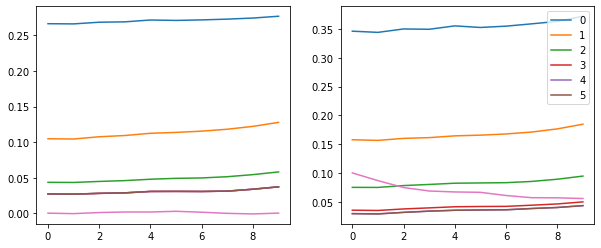

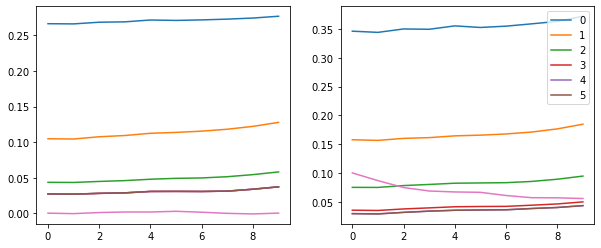

In [64]:
with Hooks(model, append_stats) as hooks:
  run.fit(2, learn)
  fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
  for h in hooks:
    ms, ss = h.stats
    ax0.plot(ms[:10])
    ax1.plot(ss[:10])
  plt.legend(range(6))

  fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4))
  for h in hooks:
    ms, ss = h.stats
    ax0.plot(ms[:10])
    ax1.plot(ss[:10])
  plt.legend(range(6))


### Other Statistics

Let's store more than the means and stds and plot histograms of our activations now.

In [0]:
def append_stats(hook, mod, inp, outp):
  if not hasattr(hook, 'stats'):
    hook.stats = ([],[],[])

  means, stds, hists = hook.stats
  means.append(outp.data.mean().cpu())
  stds.append(outp.data.mean().cpu())
  hists.append(outp.data.mean().cpu().histc(40,0,10))# histc isn't implemented on the GPU


In [0]:
model = get_cnn_model(data, nfs).cuda()
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [0]:
for l in model:
  if isinstance(l, nn.Sequential):
    init.kaiming_normal_(l[0].weight)
    l[0].bias.data.zero_()

In [0]:
with Hooks(model, append_stats) as hooks:
  run.fit(1, learn)


In [0]:
def get_hist(h):
  return torch.stack(h.stats[2]).t().float().log1p()

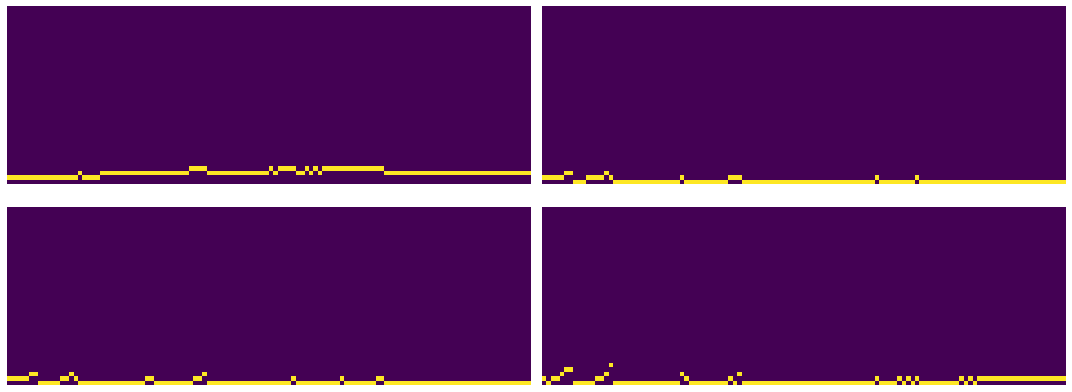

In [70]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))
for ax, h in zip(axes.flatten(),  hooks[:4]):
  ax.imshow(get_hist(h), origin='lower')
  ax.axis('off')
plt.tight_layout()

In [0]:
def get_min(h):
  h1 = torch.stack(h.stats[2]).t().float()
  return h1[:2].sum(0)/h1.sum(0)

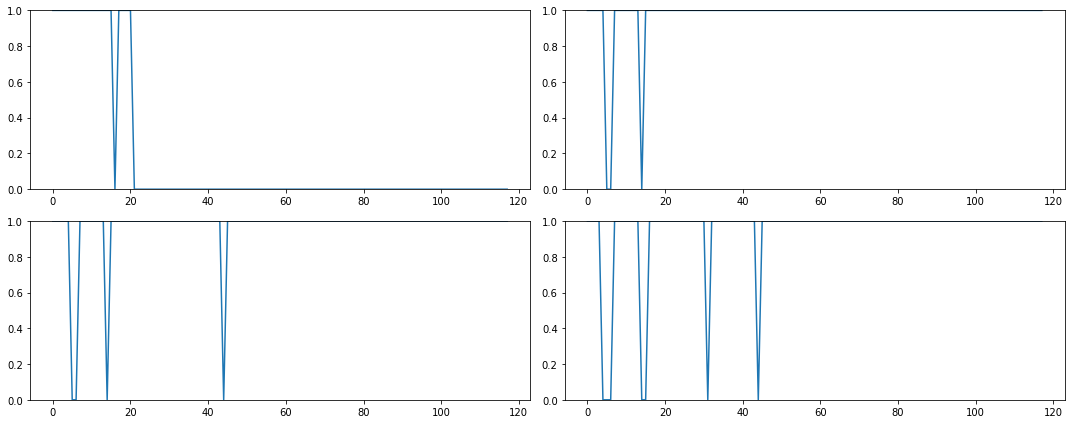

In [72]:
fig, axes = plt.subplots(2, 2, figsize=(15,6))
for ax, h in zip(axes.flatten(), hooks[:4]):
  ax.plot(get_min(h))
  ax.set_ylim(0,1)
plt.tight_layout()

## Generalized ReLU



Now let's use our model with a generalized ReLU that can be shifted and with maximum value.

In [0]:
# export
def get_cnn_layers(data, nfs, layer, **kwargs):
  nfs = [1] + nfs
  return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs) 
  for i in range(len(nfs) - 1)] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten),
                                   nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
  return nn.Sequential( 
      nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride),
      GeneralRelu(**kwargs)
  )                         

class GeneralRelu(nn.Module):
  def __init__(self, leak=None, sub=None, maxv=None):
    super().__init__()
    self.leak, self.sub, self.maxv = leak, sub, maxv

  def forward(self, x):
    x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
    if self.sub is not None: x.sub_(self.sub)
    if self.maxv  is not None: x.clamp_max_(self.maxv)
    return x

def init_cnn(m, uniform=False):
  f =  init.kaiming_uniform_  if uniform else init.kaiming_normal_
  for l in m:
    if isinstance(l, nn.Sequential):
      f(l[0].weight, a=0.1)
      l[0].bias.data.zero_()

def get_cnn_model(data, nfs, layer, **kwargs):
  return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [0]:
def append_stats(hook, mod, inp, outp):
  if not hasattr(hook, 'stats'): hook.stats=([],[],[])
  means, stds, hists = hook.stats
  means.append(outp.data.mean().cpu())
  stds.append(outp.data.std().cpu())
  hists.append(outp.data.cpu().histc(40,-7,7))

In [0]:
model = get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

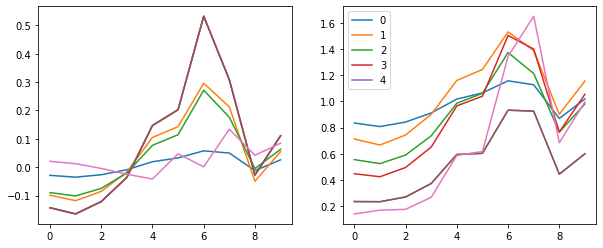

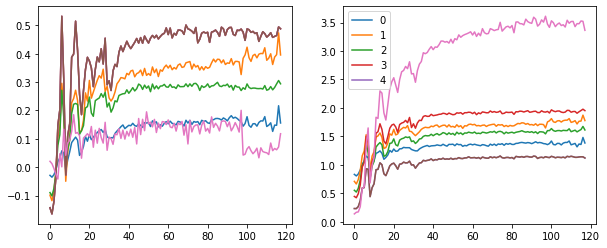

In [76]:
with Hooks(model, append_stats) as hooks:
  run.fit(1, learn)
  fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,4))
  for h in hooks:
    ms, ss, hi = h.stats
    ax0.plot(ms[:10])
    ax1.plot(ss[:10])
    h.remove()
  plt.legend(range(5))

  fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,4))
  for h in hooks:
    ms, ss, hi = h.stats
    ax0.plot(ms)
    ax1.plot(ss)
  plt.legend(range(5))

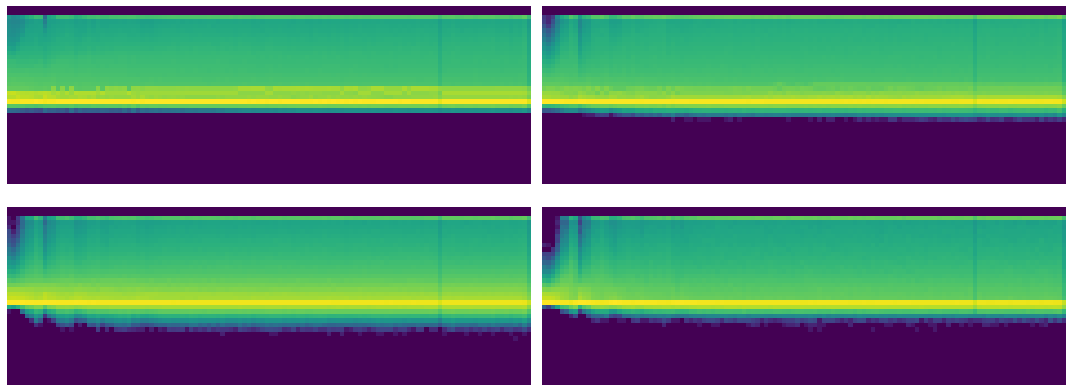

In [77]:
fig, axes = plt.subplots(2,2, figsize=(15,6))
for ax, h in zip(axes.flatten(), hooks[:4]):
  ax.imshow(get_hist(h), origin = 'lower')
  ax.axis('off')
plt.tight_layout()

In [0]:
def get_min(h):
  h1 = torch.stack(h.stats[2]).t().float()
  return h1[19:22].sum(0)/h1.sum(0)

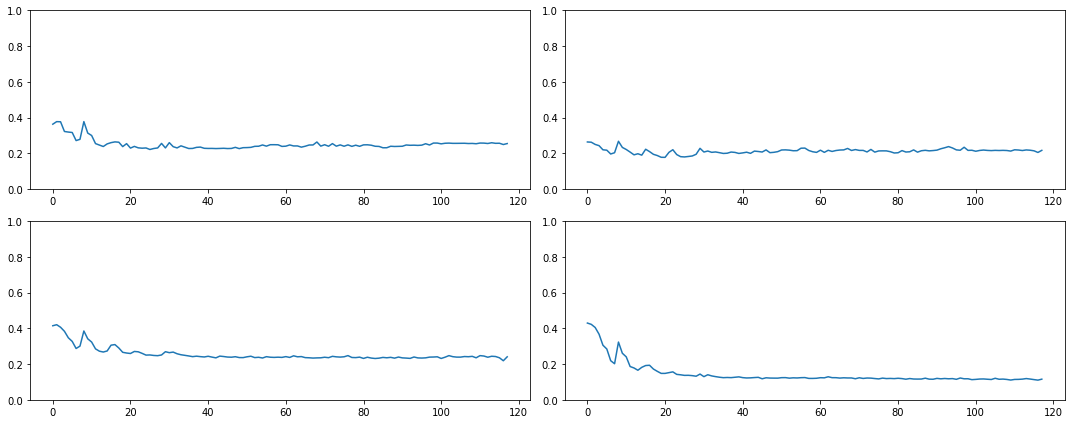

In [79]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [0]:
# export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs ):
  model = get_cnn_model(data, nfs, layer, **kwargs)
  init_cnn(model, uniform=uniform)
  return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [0]:
sched = combine_scheds([0.5,0.5 ], [sched_cos(0.2, 1), sched_cos(1., 0.1)])

In [0]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, cbs = cbfs+[partial(ParamScheduler, 'lr', sched)])

In [0]:
run.fit(8, learn)

Uniform init may provide more useful initial weights (normal distribution puts a lot of them at 0)

In [0]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, uniform=True,
                          cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [0]:
run.fit(8, learn)

## Export

In [89]:
!pip install fire

     |████████████████████████████████| 81kB 2.9MB/s 
  Created wheel for fire: filename=fire-0.2.1-py2.py3-none-any.whl size=103527 sha256=53fa651ee9c90bed2b70631028fff1de3f898cd3b7de99907691ccd42cbf8b24
  Stored in directory: /root/.cache/pip/wheels/31/9c/c0/07b6dc7faf1844bb4688f46b569efe6cafaa2179c95db821da
Successfully built fire


In [90]:
!python "/content/drive/My Drive/Colab Notebooks/notebook2script.py" "/content/drive/My Drive/Colab Notebooks/06_cuda_cnn_hooks_init.ipynb"

Converted /content/drive/My Drive/Colab Notebooks/06_cuda_cnn_hooks_init.ipynb to /content/drive/My Drive/Colab Notebooks/exp/nb_06.py
